# Implementation of Logistic Regression

The dataset I am dealing with is a list of features extracted from human blood cells. Each line in
`features.csv` corresponds to a different patient. `labels.csv` contains matching labels(0 = healthy, 1 = sick).

This notebook can be used which will help us identify whether a patient's cells are healthy or sick,
just in case one of us falls sick in the office. We probably care more about identifying all the sick people than making
a mistake about a healthy person every now and then.

Importing all sort libraries which will be required in order to run this notebook

In [23]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import seaborn as sns
from scipy import stats
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Plotting related configuration.
Also dependency of one library Chisqrprob

In [24]:
plt.rc("font", size=14)
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Taking both dataset and merging into single data frame based on Patient ID's

In [25]:
data_features = pd.read_csv("features.csv",header=0)
data_label = pd.read_csv("labels.csv",header=0)
data = pd.merge(data_features, data_label, on='ID')
data = data.dropna()

This will tell different statistic about data

In [26]:
print(data.shape)
#print(list(data.columns))
print(data['Sickness'].value_counts())

(288, 689)
0    219
1     69
Name: Sickness, dtype: int64


Plot total sick people and plot

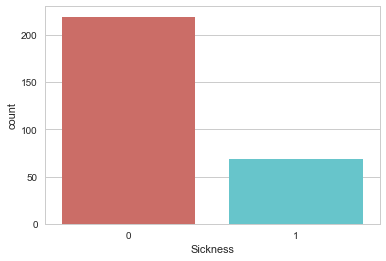

In [27]:
sns.countplot(x='Sickness', data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

Just to test, whether plotting a graph any against any features will make sense or not, which turned out to be bad idea.

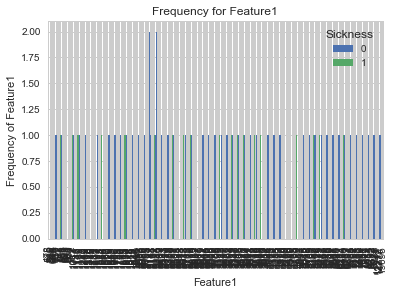

In [28]:
pd.crosstab(data.Feature1,data.Sickness).plot(kind='bar')
plt.title('Frequency for Feature1')
plt.xlabel('Feature1')
plt.ylabel('Frequency of Feature1')
plt.show()
plt.savefig('Frequency of Feature1')

********Feature Selection************

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features

***It will give one warning, but we can ignore that

In [15]:
data_final_vars=data.columns.values.tolist()
y=['Sickness','ID']
Y=['Sickness']
X=[i for i in data_final_vars if i not in y]

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(data[X], data[Y] )
print(rfe.support_)
print(rfe.ranking_)

C:\Users\vnitin\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False False False False False False False False False False
 False False False  True False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False  True False  True False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True Fa

Once feature selection are done, we can refrain above step to run again and again.
Now we have 20 features which can do training and further help in classification.

In [29]:
cols = ["Feature15","Feature23","Feature43","Feature45","Feature64",
"Feature87","Feature115","Feature127","Feature162","Feature163",
"Feature236","Feature362","Feature379","Feature442","Feature451",
"Feature452","Feature495","Feature551","Feature634","Feature655",]


X=data[cols]
y=data['Sickness']

Get Summary again each feature

In [30]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.331542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Sickness   No. Observations:                  288
Model:                          Logit   Df Residuals:                      268
Method:                           MLE   Df Model:                           19
Date:                Sat, 05 May 2018   Pseudo R-squ.:                  0.3979
Time:                        18:07:52   Log-Likelihood:                -95.484
converged:                       True   LL-Null:                       -158.57
                                        LLR p-value:                 7.684e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Feature15     -0.1438      0.079     -1.828      0.068      -0.298       0.010
Feature23     -0.1013      0.

***The p-values for most of the variables are smaller than 0.05, therefore, most of them are significant to the model

***********Let go ahead and train the model************
Split into 70% (training set) and 30% (test set)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Training the logistic regression classifier

In [32]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.77


********Cross Validation*******

Cross validation attempts to avoid overfitting while still producing a prediction for each observation dataset. We are using 10-fold Cross-Validation to train our Logistic Regression model.

In [33]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.832


********ROC Curve*********

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

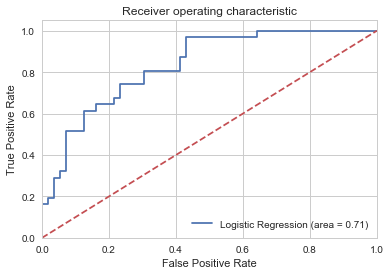

In [22]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()